In [20]:
import re
import unicodedata
import pandas as pd
import nltk

from env import get_db_url

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
from prepare import basic_clean, tokenize, remove_stopwords, stem, lemmatize

In [10]:
# Creating a function that will clean the data's text
# by lemmatizing anf choosing stopwrods from the library and adding a few more ADDITIONAL_STOPWORDS
# then Encoding and Normalizing and Lower Casing and removing unwanted characters
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


In [11]:
# Creating a table showing the values and percentages of the words in ham and spam
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [12]:
# Does the above but in a function
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")


,n,percent
ham,4825,0.865937
spam,747,0.134063


# Exploration

In [13]:
# Creates a list of all the words in ham, spam and all the words
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))


In [100]:
spam_words

['free',
 'entry',
 'wkly',
 'comp',
 'win',
 'fa',
 'cup',
 'final',
 'tkts',
 '21st',
 'may',
 '2005',
 'text',
 'fa',
 '87121',
 'receive',
 'entry',
 'questionstd',
 'txt',
 'ratetcs',
 'apply',
 '08452810075over18s',
 'freemsg',
 'hey',
 'darling',
 '3',
 'week',
 'word',
 'back',
 'id',
 'like',
 'fun',
 'still',
 'tb',
 'ok',
 'xxx',
 'std',
 'chgs',
 'send',
 'a150',
 'rcv',
 'winner',
 'valued',
 'network',
 'customer',
 'selected',
 'receivea',
 'a900',
 'prize',
 'reward',
 'claim',
 'call',
 '09061701461',
 'claim',
 'code',
 'kl341',
 'valid',
 '12',
 'hour',
 'mobile',
 '11',
 'month',
 'entitled',
 'update',
 'latest',
 'colour',
 'mobile',
 'camera',
 'free',
 'call',
 'mobile',
 'update',
 'co',
 'free',
 '08002986030',
 'six',
 'chance',
 'win',
 'cash',
 '100',
 '20000',
 'pound',
 'txt',
 'csh11',
 'send',
 '87575',
 'cost',
 '150pday',
 '6days',
 '16',
 'tsandcs',
 'apply',
 'reply',
 'hl',
 '4',
 'info',
 'urgent',
 '1',
 'week',
 'free',
 'membership',
 'a100000'

In [15]:
# Creates a frequency Series for the words
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()


call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [16]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()


,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


In [17]:
word_counts.sort_values(by='all', ascending=False).head(10)


,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5
free,275,59,216
know,267,241,26


## Are there any words that uniquely identify a spam or ham message?


In [18]:
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])


,all,ham,spam
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0
awarded,38,0,38
18,43,0,43
guaranteed,50,0,50
tone,73,0,73


# Visualiztions

Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

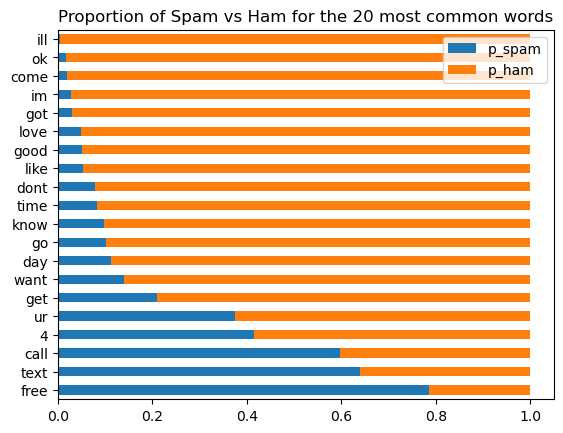

In [21]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')


<Axes: >

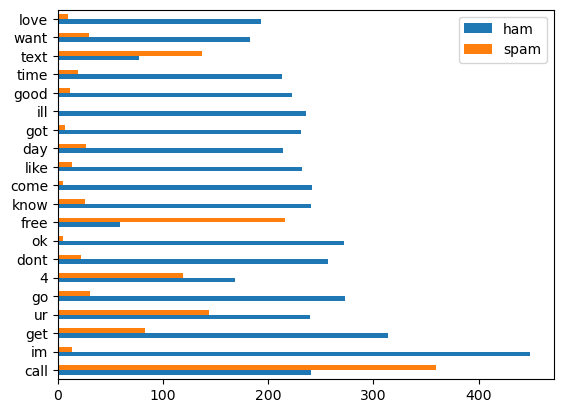

In [23]:
word_counts.sort_values('all', ascending=False)[['ham', 'spam']].head(20).plot.barh()


In [22]:
(word_counts
 [(word_counts.spam > 10) & (word_counts.ham > 10)]
 .assign(ratio=lambda df: df.spam / (df.ham + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))


,all,ham,spam,ratio
im,462,449,13,0.028953
good,235,223,12,0.053809
like,245,232,13,0.056032
need,182,171,11,0.064324
dont,279,257,22,0.085600
contact,70,14,56,3.997145
win,76,15,61,4.063957
cash,74,12,62,5.162365
mobile,150,15,135,8.994004
txt,163,13,150,11.529593


(-0.5, 399.5, 199.5, -0.5)

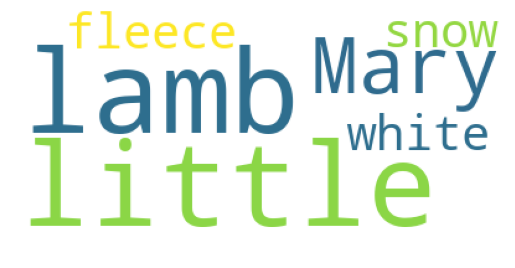

In [24]:
from wordcloud import WordCloud

sentence = 'Mary had a little lamb, little lamb, little lamb. Its fleece was white as snow.'

img = WordCloud(background_color='white').generate(sentence)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')


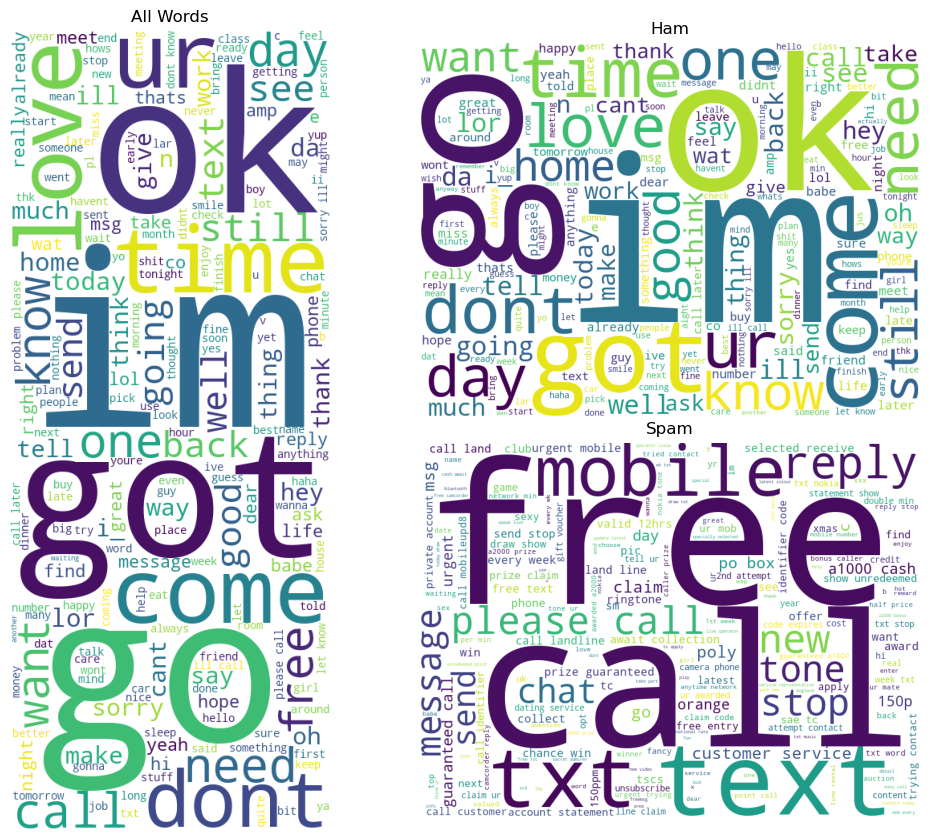

In [25]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')


In [26]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()


(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

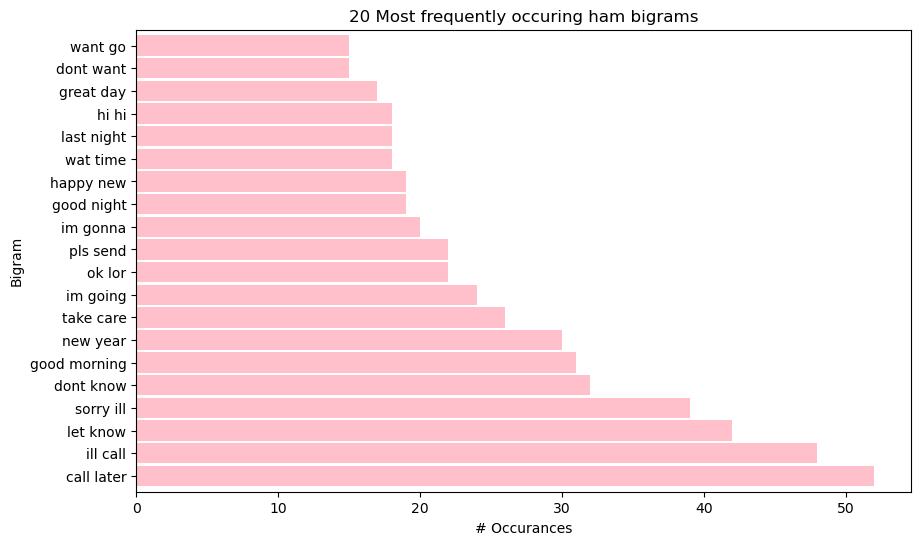

In [27]:
top_20_ham_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


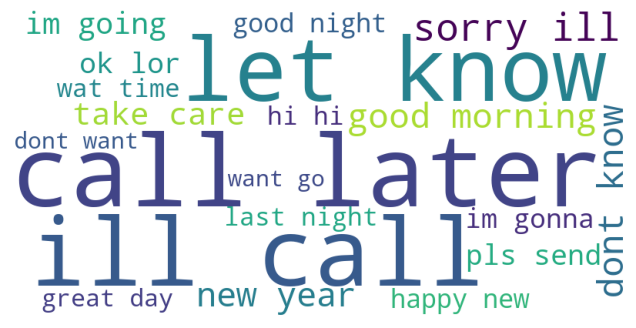

In [28]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


# Exercises

Do your work for this exercise in a file named explore.

# 1. Spam Data

* Load the spam data set.
* Create and explore bigrams for the spam data. Visualize them with a word cloud. How do * they compare with the ham bigrams?
* Is there any overlap in the bigrams for the spam data and the ham data?
* Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [30]:
# Load the spam data set
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [29]:
# Create and explore bigrams for the spam data
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))

top_20_spam_bigrams.head()


(please, call)         44
(customer, service)    27
(po, box)              24
(a1000, cash)          23
(guaranteed, call)     23
dtype: int64

### How do * they compare with the ham bigrams?

In [37]:
top_20_ham_bigrams.head(), top_20_spam_bigrams.head()

((call, later)    52
 (ill, call)      48
 (let, know)      42
 (sorry, ill)     39
 (dont, know)     32
 dtype: int64,
 (please, call)         44
 (customer, service)    27
 (po, box)              24
 (a1000, cash)          23
 (guaranteed, call)     23
 dtype: int64)

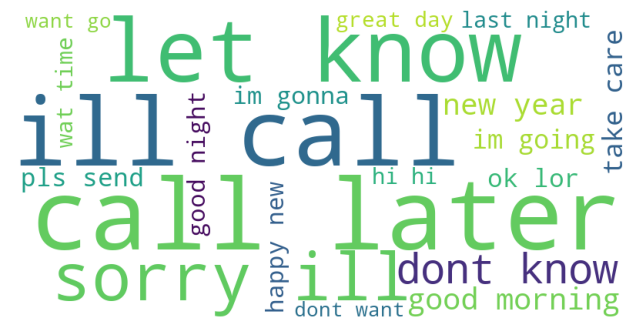

In [38]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

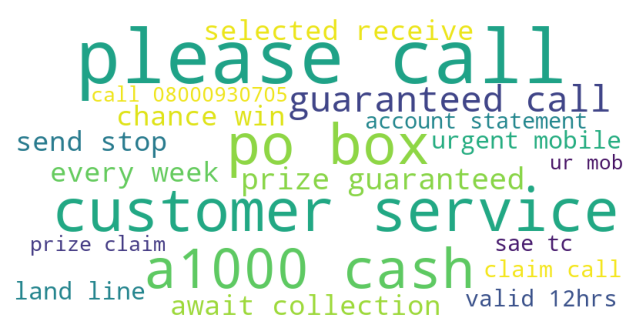

In [39]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

### Is there any overlap in the bigrams for the spam data and the ham data?
No, I don't see any overlap.

In [35]:
# Create and explore with trigrams (i.e. a n-gram with an n of 3) 
# for both the spam and ham data
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(20))

top_20_spam_trigrams.head()

(prize, guaranteed, call)     21
(call, customer, service)     15
(land, line, claim)           14
(reply, call, 08000930705)    14
(private, 2003, account)      13
dtype: int64

In [36]:
# Create and explore with trigrams (i.e. a n-gram with an n of 3) 
# for both the spam and ham data
top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts()
                      .head(20))

top_20_ham_trigrams.head()

(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(cant, pick, phone)     12
dtype: int64

# 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [40]:
from acquire import get_blog_articles, get_news_articles

In [ ]:
codeup_df = get_blog_articles()

In [46]:
codeup_df = pd.DataFrame(codeup_df)
codeup_df.head()

,title,content
0,Spotlight on APIDA Voices: Celebrating Heritag...,May is traditionally known as Asian American a...
1,Women in tech: Panelist Spotlight – Magdalena ...,Women in tech: Panelist Spotlight – Magdalena ...
2,Women in tech: Panelist Spotlight – Rachel Rob...,Women in tech: Panelist Spotlight – Rachel Rob...
3,Women in Tech: Panelist Spotlight – Sarah Mellor,Women in tech: Panelist Spotlight – Sarah Mell...
4,Women in Tech: Panelist Spotlight – Madeleine ...,Women in tech: Panelist Spotlight – Madeleine ...


In [48]:
codeup_df.title[0] = 'Arbeena Thapa'

In [51]:
codeup_df.title[1] = 'Magdalena Rahn'

In [54]:
codeup_df.title[2] = 'Rachel Robbins-Mayhill'

In [56]:
codeup_df.title[3] = 'Sarah Mellor'

In [58]:
codeup_df.title[4] = 'Madeleine Capper'

In [61]:
codeup_df.title[5] = 'Wilmarie De La Cruz Mejia'

In [62]:
codeup_df

,title,content
0,Arbeena Thapa,May is traditionally known as Asian American a...
1,Magdalena Rahn,Women in tech: Panelist Spotlight – Magdalena ...
2,Rachel Robbins-Mayhill,Women in tech: Panelist Spotlight – Rachel Rob...
3,Sarah Mellor,Women in tech: Panelist Spotlight – Sarah Mell...
4,Madeleine Capper,Women in tech: Panelist Spotlight – Madeleine ...
5,Wilmarie De La Cruz Mejia,Black excellence in tech: Panelist Spotlight –...


In [77]:
# No difference here since they all have the same number of content... 1 out of 6
labels = pd.concat([codeup_df.title.value_counts(),
                    codeup_df.title.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
Arbeena Thapa,1,0.166667
Magdalena Rahn,1,0.166667
Rachel Robbins-Mayhill,1,0.166667
Sarah Mellor,1,0.166667
Madeleine Capper,1,0.166667
Wilmarie De La Cruz Mejia,1,0.166667


In [95]:
word_count_list = [Thapa_words, Rahn_words, Robbins_Mayhill_words, Mellor_words, Capper_words, Mejia_words, all_words]

In [96]:
# Creates a list of all the words in ham, spam and all the words
Thapa_words = clean(' '.join(codeup_df[codeup_df.title == 'Arbeena Thapa'].content))
Rahn_words = clean(' '.join(codeup_df[codeup_df.title == 'Magdalena Rahn'].content))
Robbins_Mayhill_words = clean(' '.join(codeup_df[codeup_df.title == 'Rachel Robbins-Mayhill'].content))
Mellor_words = clean(' '.join(codeup_df[codeup_df.title == 'Sarah Mellor'].content))
Capper_words = clean(' '.join(codeup_df[codeup_df.title == 'Madeleine Capper'].content))
Mejia_words = clean(' '.join(codeup_df[codeup_df.title == 'Wilmarie De La Cruz Mejia'].content))
all_words = clean(' '.join(codeup_df.content))

In [79]:
# Creates a frequency Series for the words
thapa_freq = pd.Series(Thapa_words).value_counts()
rahn_freq = pd.Series(Rahn_words).value_counts()
mayhill_freq = pd.Series(Robbins_Mayhill_words).value_counts()
mellor_freq = pd.Series(Mellor_words).value_counts()
capper_freq = pd.Series(Capper_words).value_counts()
mejia_freq = pd.Series(Mejia_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

thapa_freq.head()

asian        12
apida         9
u             7
community     6
american      6
dtype: int64

In [80]:
word_counts = (pd.concat([all_freq, mejia_freq, capper_freq, mellor_freq, mayhill_freq, rahn_freq, thapa_freq], axis=1, sort=True)
                .set_axis(['all', 'mejia', 'capper', 'mellor', 'mayhill', 'rahn', 'thapa'], axis=1)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,mejia,capper,mellor,mayhill,rahn,thapa
1988,1,0,0,0,0,0,1
2019,1,0,1,0,0,0,0
2022,2,0,0,0,2,0,0
2023,7,1,1,1,2,2,0
22,1,1,0,0,0,0,0


In [81]:
word_counts.sort_values(by='all', ascending=False).head(10)


,all,mejia,capper,mellor,mayhill,rahn,thapa
codeup,24,4,4,5,5,5,1
woman,18,0,4,4,4,4,2
data,17,0,6,0,8,3,0
tech,15,3,3,3,3,3,0
science,14,0,2,0,9,3,0
asian,12,0,0,0,0,0,12
panelist,11,3,2,2,2,2,0
rachel,11,0,0,0,11,0,0
u,10,1,0,1,0,1,7
career,10,0,2,2,4,1,1


In [97]:
word_counts.columns

Index(['all', 'mejia', 'capper', 'mellor', 'mayhill', 'rahn', 'thapa'], dtype='object')

Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

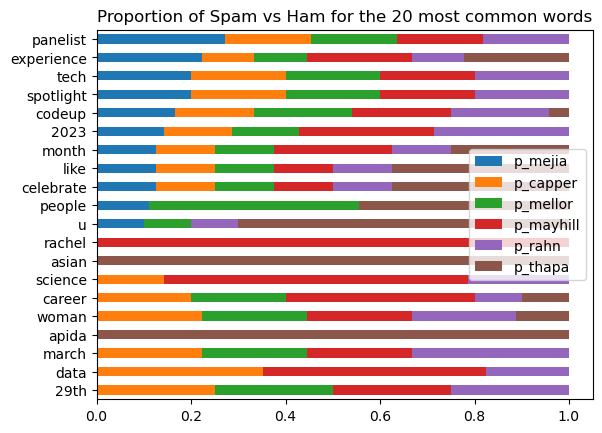

In [85]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_mejia=word_counts.mejia / word_counts['all'],
         p_capper=word_counts.capper / word_counts['all'],
        p_mellor=word_counts.mellor / word_counts['all'],
         p_mayhill=word_counts.mayhill / word_counts['all'],
        p_rahn=word_counts.rahn / word_counts['all'],
         p_thapa=word_counts.thapa / word_counts['all'])
 .sort_values(by='all')
 [['p_mejia', 'p_capper', 'p_mellor', 'p_mayhill', 'p_rahn', 'p_thapa']]
 .tail(20)
 .sort_values('p_mejia')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')


<Axes: >

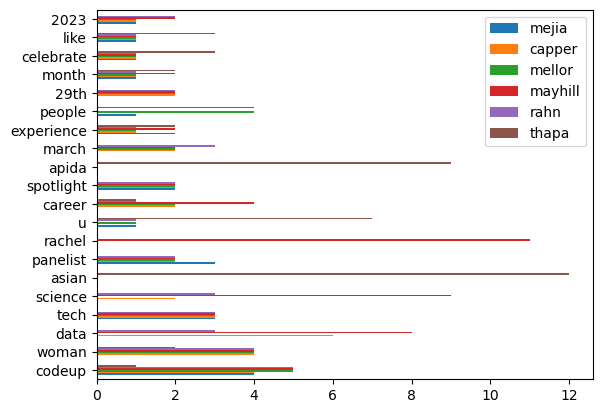

In [86]:
word_counts.sort_values('all', ascending=False)[['mejia', 'capper', 'mellor', 'mayhill', 'rahn', 'thapa']].head(20).plot.barh()


/var/folders/qh/kjmdb2zx3n3b2ng_n4q3cyn00000gn/T/ipykernel_44880/3663583754.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


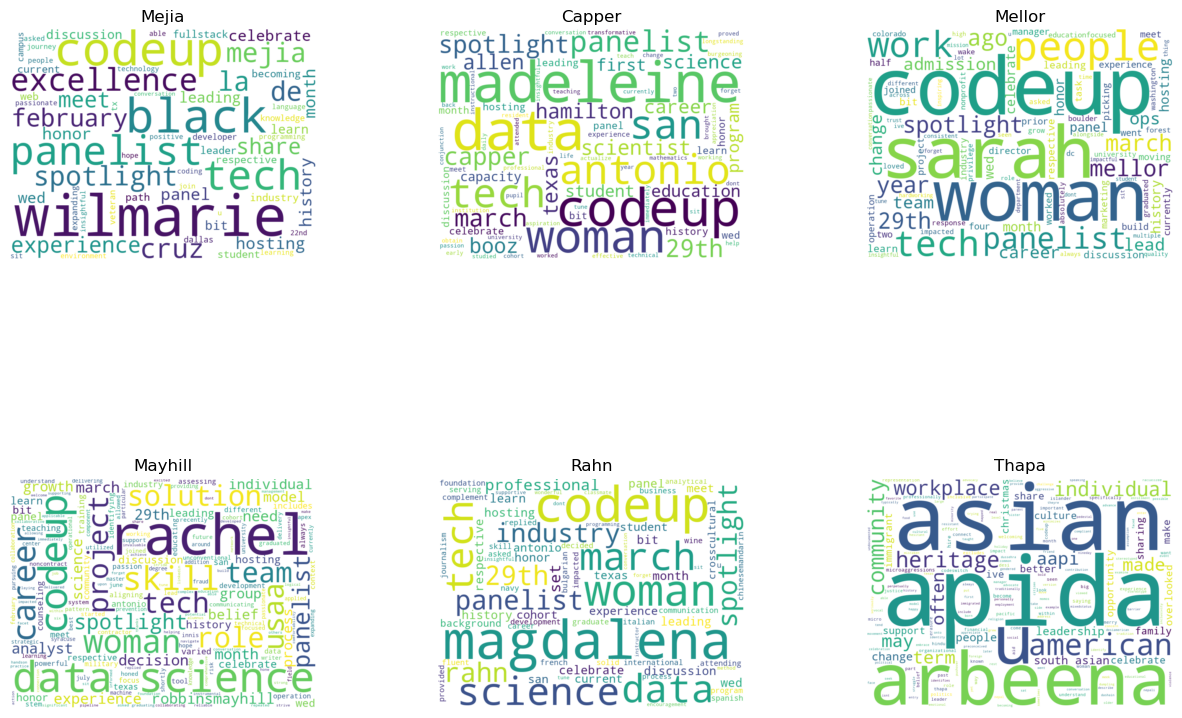

In [90]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds for different individuals
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
mejia_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(Mejia_words))
capper_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(Capper_words))
mellor_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(Mellor_words))
mayhill_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(Robbins_Mayhill_words))
rahn_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(Rahn_words))
thapa_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(Thapa_words))

# Create subplots for each individual's word cloud
plt.figure(figsize=(15, 10))

# Define the layout of subplots
grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.4)

# Plot each word cloud
axs = [
    plt.subplot(grid[0, 0]),
    plt.subplot(grid[0, 1]),
    plt.subplot(grid[0, 2]),
    plt.subplot(grid[1, 0]),
    plt.subplot(grid[1, 1]),
    plt.subplot(grid[1, 2])
]

# Plot each word cloud and set title
clouds = [
    (mejia_cloud, 'Mejia'),
    (capper_cloud, 'Capper'),
    (mellor_cloud, 'Mellor'),
    (mayhill_cloud, 'Mayhill'),
    (rahn_cloud, 'Rahn'),
    (thapa_cloud, 'Thapa')
]

for ax, (cloud, title) in zip(axs, clouds):
    ax.imshow(cloud, interpolation='bilinear')
    ax.set_title(title)

    ax.axis('off')
plt.tight_layout()
plt.show()


In [98]:
len(word_count_list)

7

In [99]:
word_count_list[0]

['may',
 'traditionally',
 'known',
 'asian',
 'american',
 'pacific',
 'islander',
 'aapi',
 'heritage',
 'month',
 'month',
 'celebrate',
 'history',
 'contribution',
 'made',
 'possible',
 'aapi',
 'friend',
 'family',
 'community',
 'also',
 'examine',
 'level',
 'support',
 'seek',
 'opportunity',
 'better',
 'understand',
 'aapi',
 'community',
 'effort',
 'address',
 'real',
 'concern',
 'experience',
 'sat',
 'arbeena',
 'thapa',
 'one',
 'codeups',
 'financial',
 'aid',
 'enrollment',
 'manager',
 'arbeena',
 'identifies',
 'nepali',
 'american',
 'desi',
 'arbeenas',
 'parent',
 'immigrated',
 'texas',
 '1988',
 'better',
 'employment',
 'educational',
 'opportunity',
 'arbeenas',
 'older',
 'sister',
 'five',
 'made',
 'move',
 'u',
 'arbeena',
 'born',
 'later',
 'becoming',
 'first',
 'family',
 'u',
 'citizen',
 'codeup',
 'take',
 'effort',
 'inclusivity',
 'seriously',
 'speaking',
 'arbeena',
 'taught',
 'term',
 'aapi',
 'excludes',
 'desiamerican',
 'individual',
 'h

In [ ]:
def bigram_series():
    
    top_20_bigrams_list = []
    
    for count in word_count_list:

        bigrams = (pd.Series(nltk.ngrams(count, 2))
                              .value_counts()
                              .head(20))

        bigram_dict = {
                        count.str() : bigrams
        }
        
    
    

# 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.